Text(0.5, 1.0, '3.5s signal of Voice ')

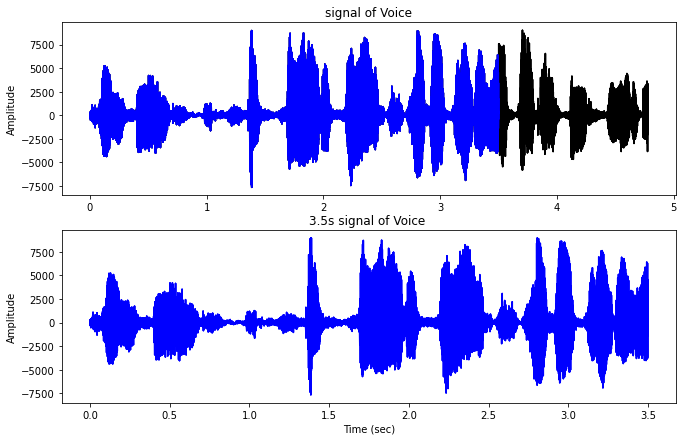

In [60]:
import numpy as np
import scipy.io.wavfile
from matplotlib import pyplot as plt
from scipy.fftpack import dct
import os
from scipy.fftpack import fft,ifft
root = "./train_audio/ID1/"
wav_file = root + "015.wav"
#采样：
sample_rate, signal = scipy.io.wavfile.read(wav_file)
#读取前3.5s
original_signal = signal[0:int(3.5*sample_rate)]

signal_num = np.arange(len(signal))
sample_num = np.arange(len(original_signal))

plt.figure(figsize=(11,7))

plt.subplot(211)
plt.plot(signal_num/sample_rate, signal, color='black')
plt.plot(sample_num/sample_rate, original_signal, color='blue')
plt.ylabel("Amplitude")
plt.title("signal of Voice")

plt.subplot(212)
plt.plot(sample_num/sample_rate, original_signal, color='blue')
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude") 
plt.title("3.5s signal of Voice ")


预加重：
$$ y[n] = x[n] - \mu * x[n-1] $$



Text(0.5, 1.0, 'emphasized signal of Voice')

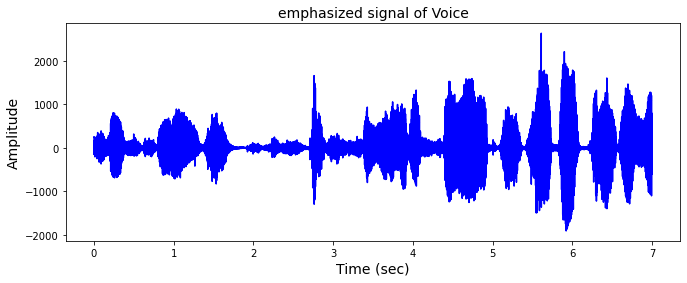

In [61]:
def pre_emphasis(signal):
    miu = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - miu * signal[:-1])
    emphasized_signal_num = np.arange(len(emphasized_signal))
    return emphasized_signal, emphasized_signal_num

signal_emphasis, range_emphasis = pre_emphasis(original_signal)

# 绘图 02
plt.figure(figsize=(11,4))

plt.plot(range_emphasis/sample_rate, signal_emphasis, color='blue')
plt.xlabel("Time (sec)", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)
plt.title("emphasized signal of Voice", fontsize=14)


2 分帧

预加重后，我们需要将信号分成短时帧。这一步背后的基本原理是信号中的频率随时间而变化，所以在大多数情况下，对整个信号进行傅立叶变换是没有意义的，因为我们会随着时间的推移丢失信号的频率轮廓。为了避免这种情况，我们可以安全地假设信号中的频率在很短的时间内是平稳的。因此，通过在这个短时间帧内进行傅里叶变换，我们可以通过连接相邻帧来获得信号的频率轮廓的良好近似。

语音处理范围内的典型帧大小范围为20毫秒到40毫秒，连续帧之间重叠50％（+/- 10％）。流行设置25毫秒的帧大小，frame_size = 0.025和-10毫秒的步幅（15毫秒重叠）， frame_stride = 0.01。

Text(0.5, 1.0, 'pad signal of Voice')

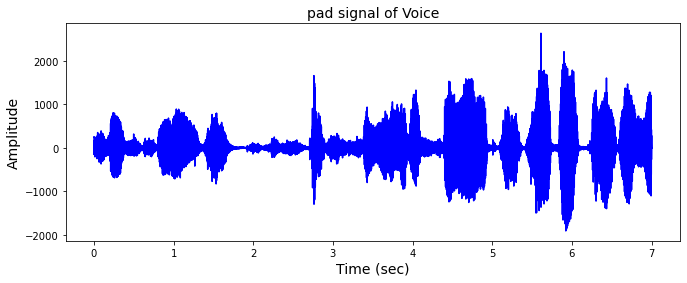

In [62]:
def framing(signal,sample_rate):
    frame_size = 0.025  # 帧长25ms
    frame_stride = 0.01 # 上一帧的开始和下一帧的开始间隔10ms，即拥有15ms的重叠
    frame_length = int(round(frame_size*sample_rate)) # 单位转化为采样点数
    frame_step = int(round(frame_stride*sample_rate)) 
    signal_length = len(signal)
    num_frames = int(np.ceil( (float((signal_length - frame_length)) / frame_step) ))# 帧数量
    frames = np.zeros([num_frames,frame_length])

    new_signal = np.append(signal, np.zeros((num_frames * frame_step + frame_length - signal_length))) #不够的部分补0
    for id in range(num_frames):
        frames[id] = new_signal[id * frame_step : id * frame_step + frame_length]
    return frames,new_signal

frames, signal_frame = framing(signal_emphasis,sample_rate) 
# 绘图 03
plt.figure(figsize=(11,4))

pad_signal_num = np.arange(len(signal_frame))
plt.plot(pad_signal_num/sample_rate, signal_frame, color='blue')
plt.xlabel("Time (sec)", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)
plt.title("pad signal of Voice", fontsize=14)

3 加窗、FFT

将每一帧乘以汉明窗，以增加帧左端和右端的连续性

由于信号在时域上的变换通常很难看出信号的特性，所以通常将它转换为频域上的能量分布来观察，不同的能量分布，就能代表不同语音的特性。所以在乘上汉明窗后，每帧还必须再经过快速傅里叶变换以得到在频谱上的能量分布。对分帧加窗后的各帧信号进行快速傅里叶变换得到各帧的频谱。并对语音信号的频谱取模平方得到语音信号的功率谱。

Text(0.5, 1.0, 'pad signal of Voice')

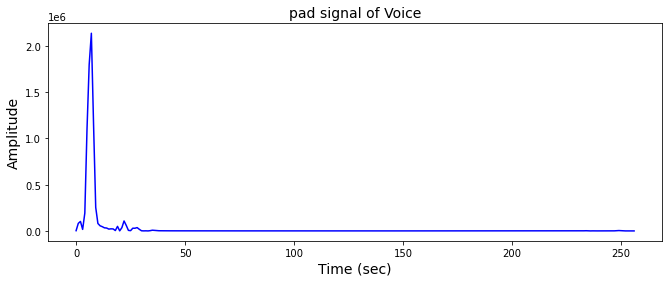

In [63]:
N_FFT = 512
def hamming_and_fft(frames,N_fft):
    [frame_number,frame_length] = frames.shape
    frames_new = frames * np.hamming(frame_length)
    mag_frames = np.abs(np.fft.rfft(frames_new, N_fft))
    pow_frames = (1.0 / N_fft) * (mag_frames ** 2)
    return pow_frames

pow_frames = hamming_and_fft(frames,N_FFT)
pow_length = len(pow_frames[0])



plt.figure(figsize=(11,4))
xx = np.arange(pow_length)
plt.plot(xx, pow_frames[20], color='blue')
plt.xlabel("Time (sec)", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)
plt.title("pad signal of Voice", fontsize=14)

5. 三角带通滤波器 （Mel滤波）


In [66]:
# 将频率转换为Mel频率
def mel_filter(frames,N_fft,sample_rate):
    low_freq_mel = 0
    filter_num = 40
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, filter_num + 2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((N_fft + 1) * hz_points / sample_rate)
    fbank = np.zeros((filter_num, int(np.floor(N_fft / 2 + 1))))
    for m in range(1, filter_num + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    return filter_banks

filter_banks = mel_filter(pow_frames,N_FFT,sample_rate)
print(filter_banks.shape)




(698, 40)


6 获取mfcc并改善


(698, 12)


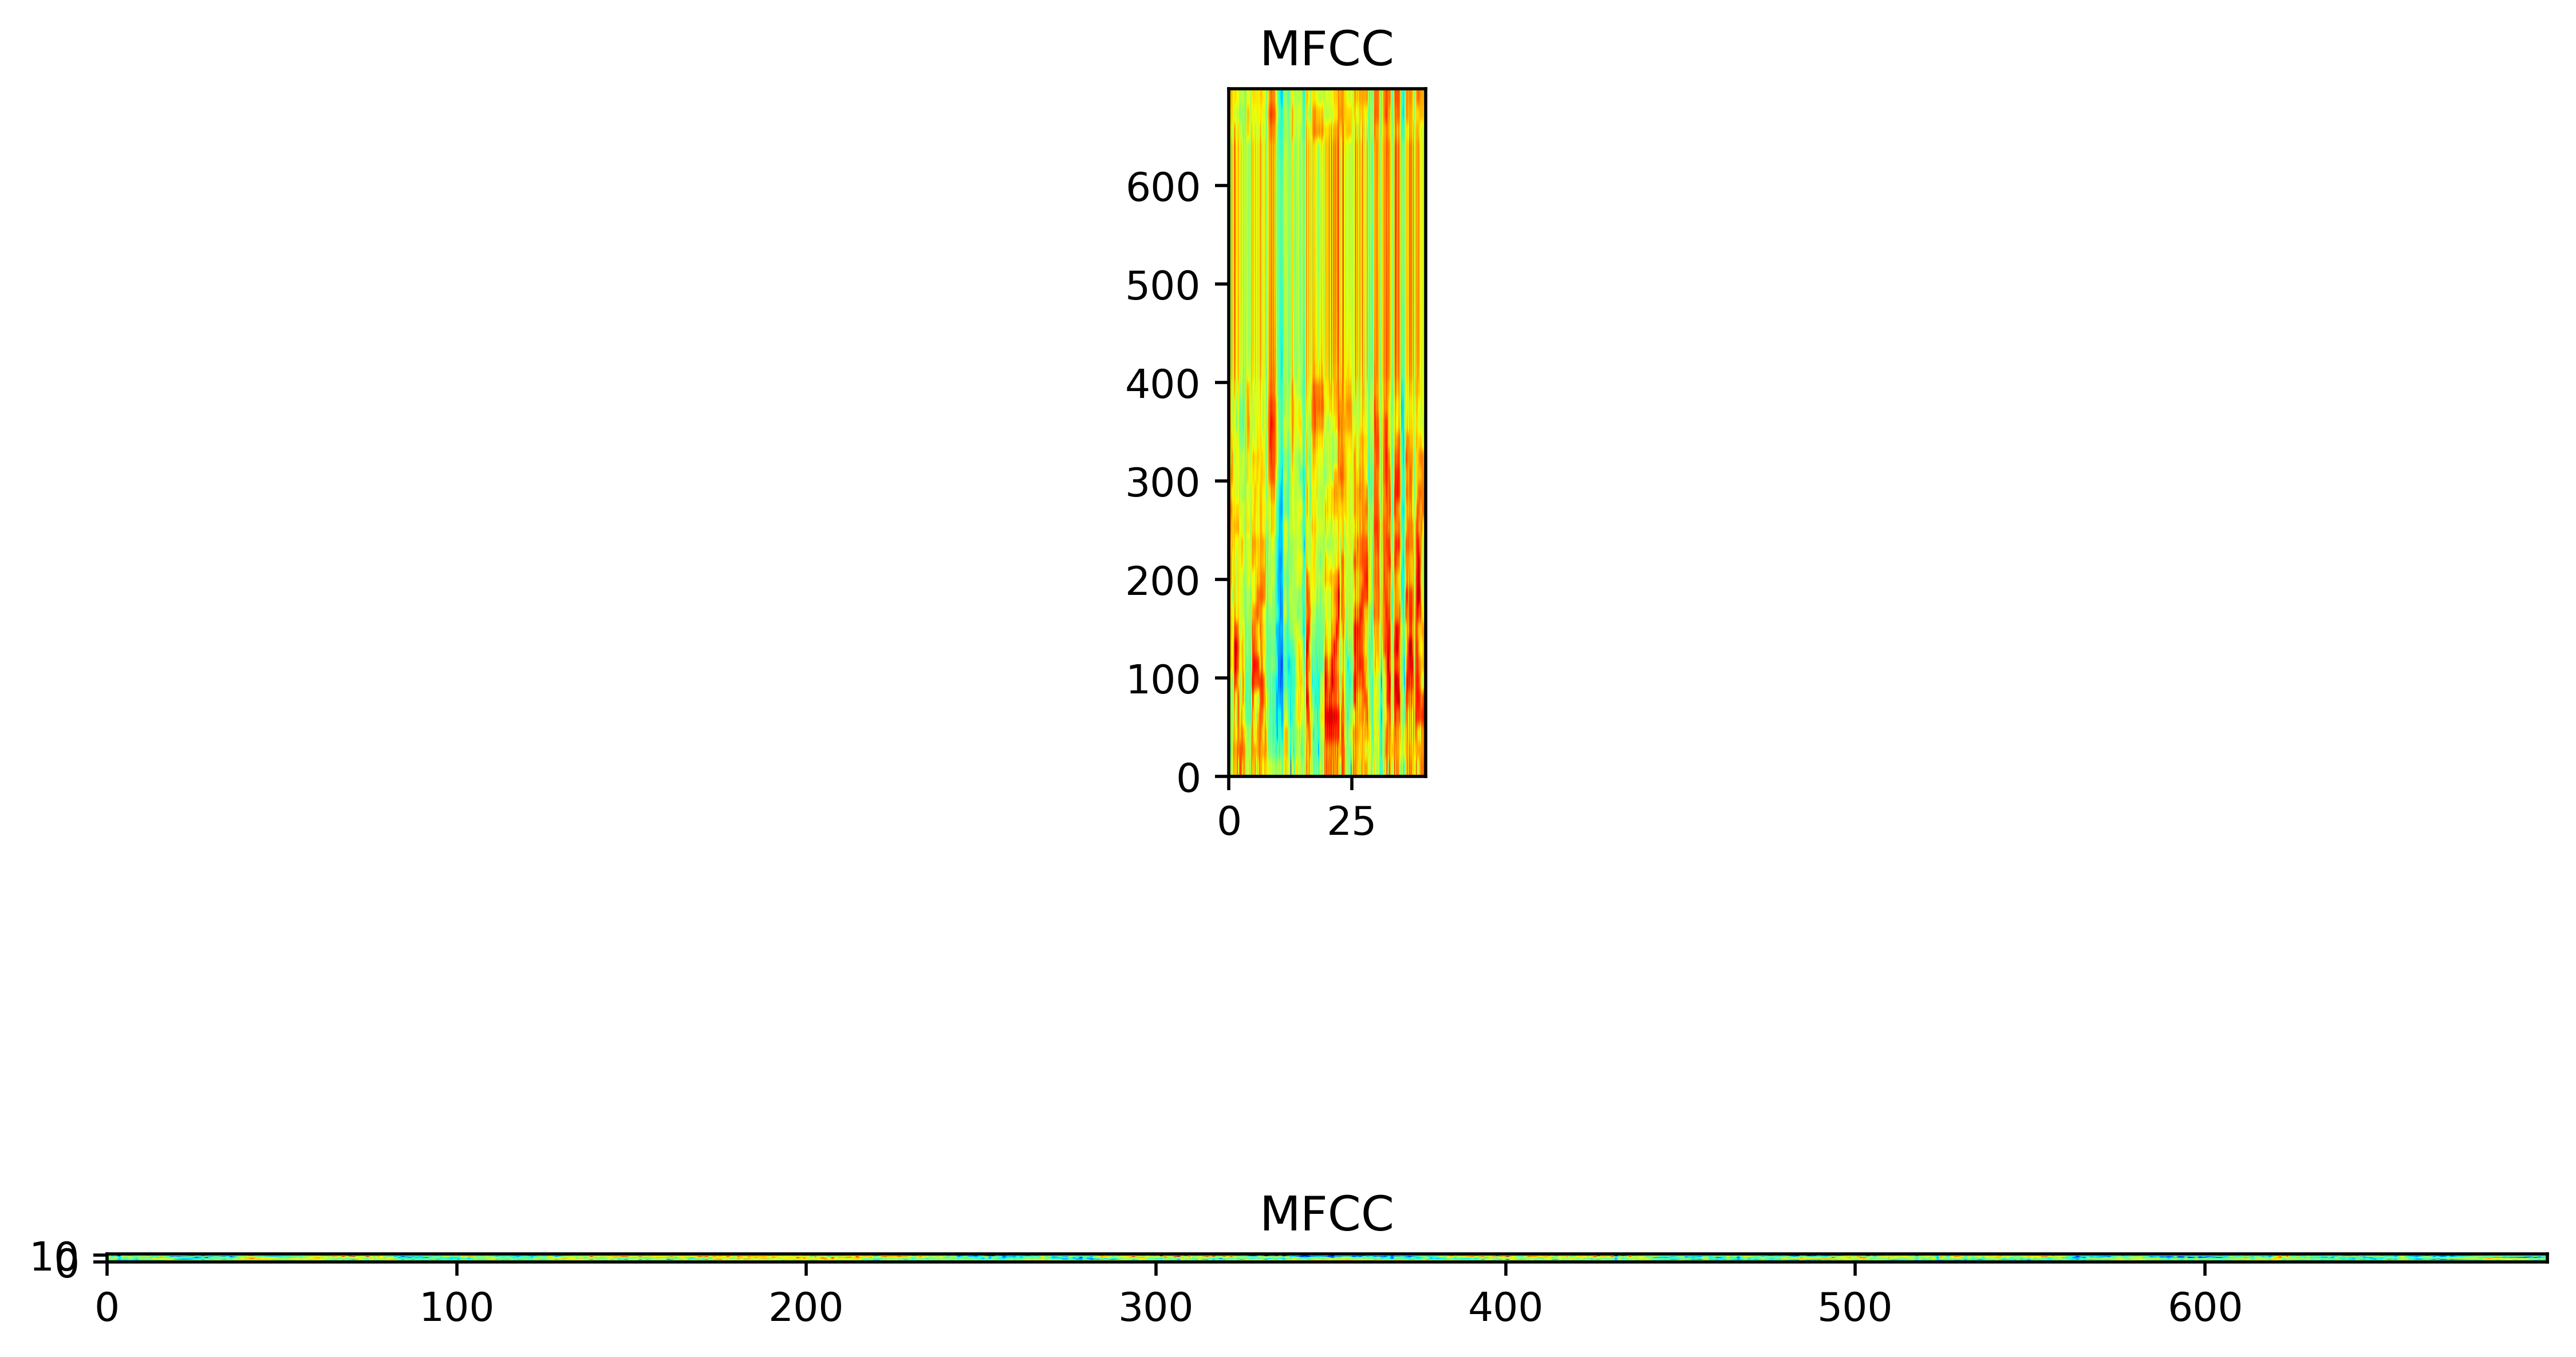

In [67]:
def getmfcc(filter_banks):
    num_ceps = 12
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    cep_lifter =22
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    return mfcc

mfcc = getmfcc(filter_banks)
print(mfcc.shape)
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

# 绘图 04
plt.figure(figsize=(11,7), dpi=500)

plt.subplot(211)
plt.imshow(np.flipud(filter_banks.T), cmap=plt.cm.jet, aspect=0.2, extent=[0,filter_banks.shape[1],0,filter_banks.shape[0]]) #画热力图
plt.title("MFCC")

plt.subplot(212)
plt.imshow(np.flipud(mfcc.T), cmap=plt.cm.jet, aspect=0.2, extent=[0,mfcc.shape[0],0,mfcc.shape[1]])#热力图
plt.title("MFCC")

plt.savefig('mfcc_04.png')

In [ ]:
7 差分和帧能量


In [ ]:
def mfcc_full(original_frames):
    amp = original_frames ** 2
    amp = np.sum(amp,axis=1)
    

In [75]:
a = np.zeros([2,2])
a[0] = np.array([1,2])
a[1] = np.array([3,4])
b = np.array([[1],[2]])
print(a)
print(b)
c = np.append(a,b)
np.sum(a,1)

[[1. 2.]
 [3. 4.]]
[[1]
 [2]]


array([3., 7.])